## Connect to Google Drive

In [12]:
#Connect to my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing necessary libraries

In [13]:
!pip install kmodes
!pip install matplotlib
!pip install optuna



## Importing Library files

In [14]:
#import Library files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import optuna  # For Bayesian optimization


# 1.Lad Data and change column names and do some preprocessings

In [15]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Student Attitude and Behavior.csv')

In [16]:
#initial chek for column names
print(df.columns)

Index(['Certification Course', 'Gender', 'Department', 'Height(CM)',
       'Weight(KG)', '10th Mark', '12th Mark', 'college mark', 'hobbies',
       'daily studing time', 'prefer to study in', 'salary expectation',
       'Do you like your degree?',
       'willingness to pursue a career based on their degree  ',
       'social medai & video', 'Travelling Time ', 'Stress Level ',
       'Financial Status', 'part-time job'],
      dtype='object')


In [17]:
# remove extra whitespace
# used to remove any leading or trailing whitespace characters from the column names in your DataFrame
df.columns = df.columns.str.strip()

# Rename columns if needed
df.rename(columns={
    "Certification Course": "certificationcourse",
    "Gender": "gender",
    "Height(CM)": "height",
    "Weight(KG)": "weight",
    "10th Mark": "mark10th",
    "12th Mark": "mark12th",
    "college mark": "collegemark",
    "daily studing time": "studytime",
    "prefer to study in": "prefertimetostudy",
    "salary expectation": "salexpect",
    "Do you like your degree?": "degreelike",
    "willingness to pursue a career based on their degree": "carrer_willingness",
    "social medai & video": "socialmed_time",
    "Travelling Time": "travelTime",
    "Stress Level": "stresslevel",
    "Financial Status": "financial",
    "part-time job": "parttime"
}, inplace=True)

print(df.columns)

Index(['certificationcourse', 'gender', 'Department', 'height', 'weight',
       'mark10th', 'mark12th', 'collegemark', 'hobbies', 'studytime',
       'prefertimetostudy', 'salexpect', 'degreelike', 'carrer_willingness',
       'socialmed_time', 'travelTime', 'stresslevel', 'financial', 'parttime'],
      dtype='object')


## Check data types

In [18]:
print(df.dtypes)

certificationcourse     object
gender                  object
Department              object
height                 float64
weight                 float64
mark10th               float64
mark12th               float64
collegemark            float64
hobbies                 object
studytime               object
prefertimetostudy       object
salexpect                int64
degreelike              object
carrer_willingness      object
socialmed_time          object
travelTime              object
stresslevel             object
financial               object
parttime                object
dtype: object


In [19]:
#print 1st 5 record of the data to check
df.head()

,certificationcourse,gender,Department,height,weight,mark10th,mark12th,collegemark,hobbies,studytime,prefertimetostudy,salexpect,degreelike,carrer_willingness,socialmed_time,travelTime,stresslevel,financial,parttime
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


# Data preprocessing

## Remove the % sign

In [20]:
# Ensure the column is of string type, then remove the % sign and convert to float
df["carrer_willingness"] = df["carrer_willingness"].astype(str).str.replace("%", "")
df["carrer_willingness"] = df["carrer_willingness"].astype(float)

# Display the updated DataFrame
df.head()

,certificationcourse,gender,Department,height,weight,mark10th,mark12th,collegemark,hobbies,studytime,prefertimetostudy,salexpect,degreelike,carrer_willingness,socialmed_time,travelTime,stresslevel,financial,parttime
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50.0,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75.0,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50.0,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50.0,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25.0,1.30 - 2 hour,30 - 60 minutes,Good,good,No


## Standardize text

In [21]:
# Standardize text case in columns for consistency
df['certificationcourse'] = df['certificationcourse'].str.capitalize()
df['gender'] = df['gender'].str.capitalize()
df['hobbies'] = df['hobbies'].str.capitalize()
df['studytime'] = df['studytime'].str.capitalize()
df['prefertimetostudy'] = df['prefertimetostudy'].str.capitalize()
df['degreelike'] = df['degreelike'].str.capitalize()
df['socialmed_time'] = df['socialmed_time'].str.capitalize()
df['travelTime'] = df['travelTime'].str.capitalize()
df['stresslevel'] = df['stresslevel'].str.capitalize()
df['financial'] = df['financial'].str.capitalize()
df['parttime'] = df['parttime'].str.capitalize()

# Display the updated DataFrame
df.head()

,certificationcourse,gender,Department,height,weight,mark10th,mark12th,collegemark,hobbies,studytime,prefertimetostudy,salexpect,degreelike,carrer_willingness,socialmed_time,travelTime,stresslevel,financial,parttime
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video games,0 - 30 minute,Morning,40000,No,50.0,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75.0,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 hour,Anytime,13000,Yes,50.0,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 hour,Anytime,1500000,No,50.0,1.30 - 2 hour,0 - 30 minutes,Bad,Good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video games,30 - 60 minute,Morning,50000,Yes,25.0,1.30 - 2 hour,30 - 60 minutes,Good,Good,No


## Check for Null **values**

In [22]:
# Check for NaN values in all columns
nan_counts = df.isna().sum()

# Display the counts of NaN values for each column
print(nan_counts)


certificationcourse    0
gender                 0
Department             0
height                 0
weight                 0
mark10th               0
mark12th               0
collegemark            0
hobbies                0
studytime              0
prefertimetostudy      0
salexpect              0
degreelike             0
carrer_willingness     0
socialmed_time         0
travelTime             0
stresslevel            0
financial              0
parttime               0
dtype: int64


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   certificationcourse  235 non-null    object 
 1   gender               235 non-null    object 
 2   Department           235 non-null    object 
 3   height               235 non-null    float64
 4   weight               235 non-null    float64
 5   mark10th             235 non-null    float64
 6   mark12th             235 non-null    float64
 7   collegemark          235 non-null    float64
 8   hobbies              235 non-null    object 
 9   studytime            235 non-null    object 
 10  prefertimetostudy    235 non-null    object 
 11  salexpect            235 non-null    int64  
 12  degreelike           235 non-null    object 
 13  carrer_willingness   235 non-null    float64
 14  socialmed_time       235 non-null    object 
 15  travelTime           235 non-null    obj

In [24]:
#get duplication details
df.duplicated().sum()

0

# Analysze the data & Do some Descriptive statistical analysis based on the data

In [25]:
#describe data set
df.describe()

,height,weight,mark10th,mark12th,collegemark,salexpect,carrer_willingness
count,235.000000,235.000000,235.000000,235.000000,235.000000,2.350000e+02,235.000000
mean,157.402128,60.803830,76.848511,68.775872,70.660553,3.248168e+04,69.574468
std,21.510805,14.895844,13.047560,11.018192,15.727446,1.113146e+05,21.178671
min,4.500000,20.000000,7.400000,45.000000,1.000000,0.000000e+00,0.000000
25%,152.000000,50.000000,70.000000,60.000000,60.000000,1.500000e+04,50.000000
50%,160.000000,60.000000,80.000000,69.000000,70.000000,2.000000e+04,75.000000
75%,170.000000,70.000000,86.250000,76.000000,80.000000,2.500000e+04,75.000000
max,192.000000,106.000000,98.000000,94.000000,100.000000,1.500000e+06,100.000000


## Find out uniq values in categorical variables

In [26]:
hobbies=df["hobbies"].unique()
studytime=df["studytime"].unique()
prefertimetostudy=df["prefertimetostudy"].unique()
degreelike=df["degreelike"].unique()
socialmed_time=df["socialmed_time"].unique()
travelTime=df["travelTime"].unique()
stresslevel=df["stresslevel"].unique()
financial=df["financial"].unique()

print('*Hobbies:',hobbies)
print('*Prefered stydy time:',prefertimetostudy)
print('*Study time duration:',studytime)
print('*Degree:',degreelike)
print('*Social media time:',socialmed_time)
print('*Travelling time:',travelTime)
print('*Stress Level:',stresslevel)
print('*Financial Level:',financial)

*Hobbies: ['Video games' 'Cinema' 'Reading books' 'Sports']
*Prefered stydy time: ['Morning' 'Anytime' 'Night']
*Study time duration: ['0 - 30 minute' '30 - 60 minute' '1 - 2 hour' '2 - 3 hour' '3 - 4 hour'
 'More than 4 hour']
*Degree: ['No' 'Yes']
*Social media time: ['1.30 - 2 hour' '1 - 1.30 hour' 'More than 2 hour' '30 - 60 minute'
 '1 - 30 minute' '0 minute']
*Travelling time: ['30 - 60 minutes' '0 - 30 minutes' '1 - 1.30 hour' '2 - 2.30 hour'
 '1.30 - 2 hour' 'More than 3 hour' '2.30 - 3 hour']
*Stress Level: ['Bad' 'Awful' 'Good' 'Fabulous']
*Financial Level: ['Bad' 'Good' 'Awful' 'Fabulous']


# Statistical Analysis Code for check the relationship between stress level and other variables

Correlation with Numeric Stress Level:
height                 0.088994
weight                -0.003104
mark10th              -0.033776
mark12th               0.119238
collegemark            0.062149
salexpect             -0.082521
stresslevel_numeric    1.000000
Name: stresslevel_numeric, dtype: float64


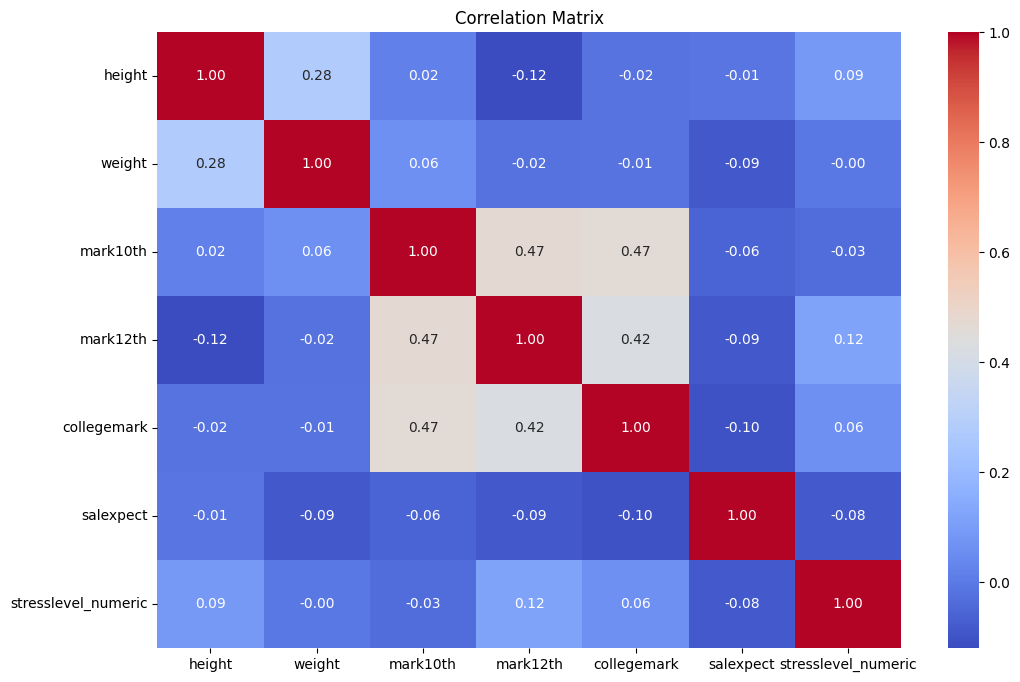

In [27]:
from scipy import stats
from scipy.stats import mannwhitneyu

# Convert categorical variables into numerical representations and Define categorical columns for encoding
categorical_columns = [
    'hobbies', 'studytime', 'prefertimetostudy', 'degreelike',
    'carrer_willingness', 'socialmed_time', 'travelTime',
    'financial', 'gender', 'Department'
]

# Check for existing columns and filter only those that are present
existing_columns = [col for col in categorical_columns if col in df.columns]

# Encode the categorical variables
df_encoded = pd.get_dummies(df, columns=existing_columns, drop_first=True)

# Map categorical stress levels to numeric values
stress_mapping = {
    'Awful': 1,
    'Bad': 2,
    'Good': 3,
    'Fabulous': 4
}
df['stresslevel_numeric'] = df['stresslevel'].map(stress_mapping)

# Create a separate DataFrame for numerical values
df_numeric = df_encoded.copy()
df_numeric['stresslevel_numeric'] = df['stresslevel_numeric']

# Filter to keep only numeric columns in the new DataFrame
df_numeric = df_numeric.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Extract the correlation with numeric stress level
stress_correlation = correlation_matrix['stresslevel_numeric']
print("Correlation with Numeric Stress Level:")
print(stress_correlation)

# Plotting the heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Perform ANOVA for career willingness (if it's a scaled category)
career_groups = [group['stresslevel_numeric'] for _, group in df.groupby('carrer_willingness')]
f_val, p_val = stats.f_oneway(*career_groups)
print(f"ANOVA for career willingness -> F-value: {f_val}, p-value: {p_val}")

# Perform ANOVA for other categorical variables
for col in existing_columns:
    if col in df.columns:
        group_data = [group['stresslevel_numeric'] for _, group in df.groupby(col)]

        if len(group_data) > 1:
            f_val, p_val = stats.f_oneway(*group_data)
            print(f"ANOVA for {col} -> F-value: {f_val}, p-value: {p_val}")
        else:
            print(f"Not enough groups to perform ANOVA for {col}.")

# T-tests for binary categorical variables
binary_columns = ['degreelike', 'parttime']
for col in binary_columns:
    if col in df.columns:
        group1 = df[df[col] == 'Yes']['stresslevel_numeric']
        group2 = df[df[col] == 'No']['stresslevel_numeric']
        t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
        print(f"T-test for {col} -> T-statistic: {t_stat}, p-value: {p_val}")


# ===================Descriptive graphs  ==================

ANOVA for career willingness -> F-value: 0.7418197978937575, p-value: 0.564359765289596
ANOVA for hobbies -> F-value: 0.7426453549701995, p-value: 0.5276187668183523
ANOVA for studytime -> F-value: 1.7471658176891636, p-value: 0.12480163585139846
ANOVA for prefertimetostudy -> F-value: 1.2939721707203415, p-value: 0.27615076558281176
ANOVA for degreelike -> F-value: 0.09145011272670839, p-value: 0.7626114497509202
ANOVA for carrer_willingness -> F-value: 0.7418197978937575, p-value: 0.564359765289596
ANOVA for socialmed_time -> F-value: 1.5996655646472053, p-value: 0.16109391543026752
ANOVA for travelTime -> F-value: 0.9554860503240454, p-value: 0.45627746275832815
ANOVA for financial -> F-value: 2.843992197057179, p-value: 0.038494652970018535
ANOVA for gender -> F-value: 0.14293638786137142, p-value: 0.705723325894215
ANOVA for Department -> F-value: 1.0515608568933081, p-value: 0.3705251593427182
T-test for degreelike -> T-statistic: 0.3024071968831255, p-value: 0.7626114497509288
T

<ipython-input-28-b9feb01367f5>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(df["certificationcourse"].unique()))


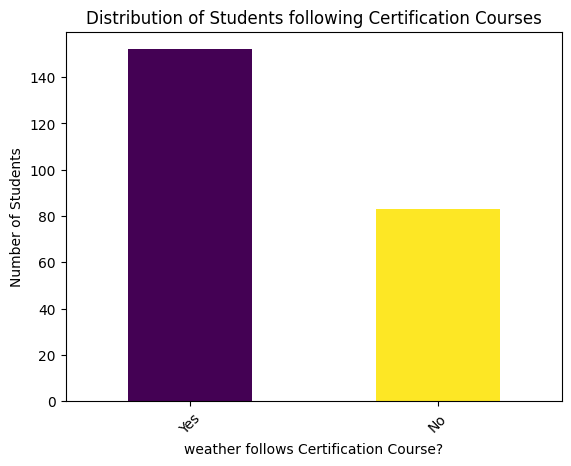

In [28]:
# There are more students who are doing cerification course
# Create a color palette
colors = plt.cm.get_cmap("viridis", len(df["certificationcourse"].unique()))

# Plot the value counts of certification courses with different colors
df["certificationcourse"].value_counts().plot(kind="bar", color=colors(range(len(df["certificationcourse"].unique()))))

# Add labels and title
plt.xlabel("weather follows Certification Course?")
plt.ylabel("Number of Students")
plt.title("Distribution of Students following Certification Courses")
plt.xticks(rotation=45)
plt.show()



<ipython-input-29-f910f51bcb27>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("plasma", len(df["gender"].unique()))#inferno/plasma/viridis colors


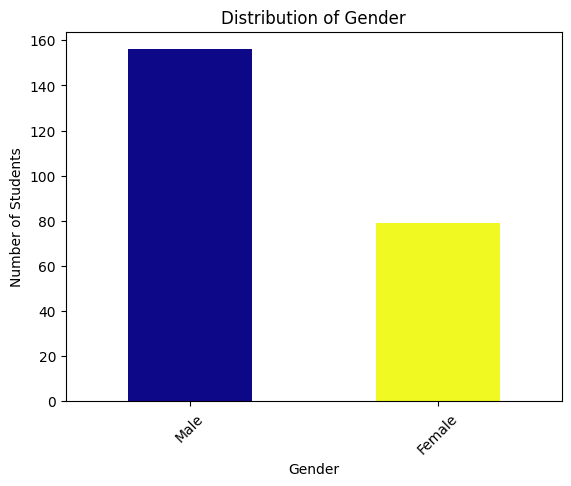

In [29]:
# Create a color palette
colors = plt.cm.get_cmap("plasma", len(df["gender"].unique()))#inferno/plasma/viridis colors

# Plot the value counts of certification courses with different colors
df["gender"].value_counts().plot(kind="bar", color=colors(range(len(df["gender"].unique()))))

# Add labels and title
plt.xlabel("Gender")
plt.ylabel("Number of Students")
plt.title("Distribution of Gender")
plt.xticks(rotation=45)
plt.show()

<ipython-input-30-83b6eb1f7d68>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("plasma", len(df["Department"].unique()))#inferno/plasma/viridis colors


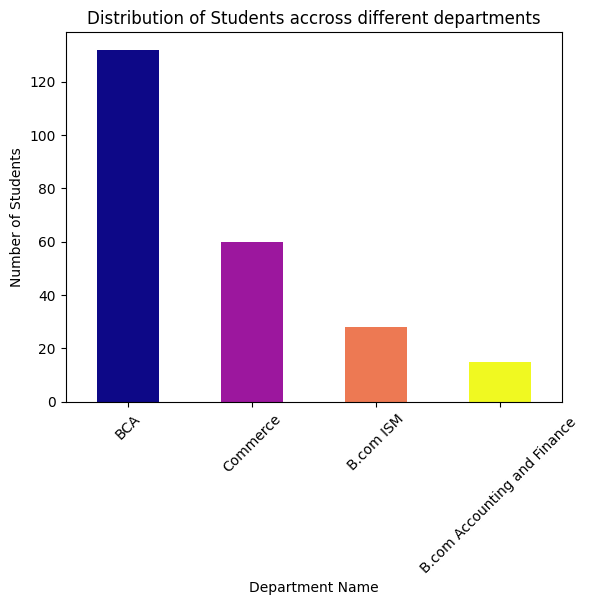

In [30]:
# Create a color palette
colors = plt.cm.get_cmap("plasma", len(df["Department"].unique()))#inferno/plasma/viridis colors

# Plot the value counts of certification courses with different colors
df["Department"].value_counts().plot(kind="bar", color=colors(range(len(df["Department"].unique()))))

# Add labels and title
plt.xlabel("Department Name")
plt.ylabel("Number of Students")
plt.title("Distribution of Students accross different departments")
plt.xticks(rotation=45)
plt.show()

<ipython-input-31-5f7f68d4d0c0>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(df["hobbies"].unique()))#inferno/plasma/viridis colors


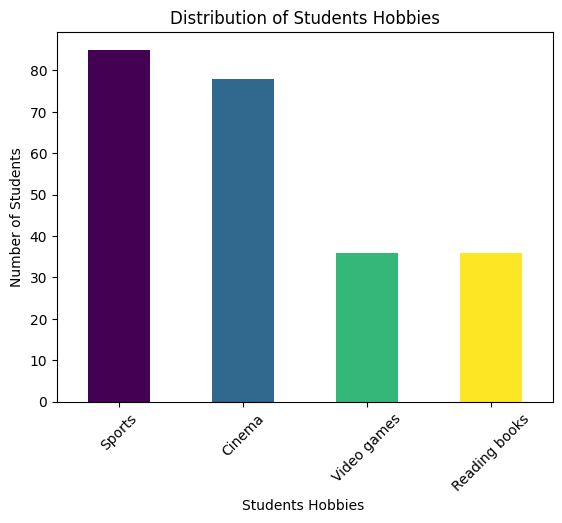

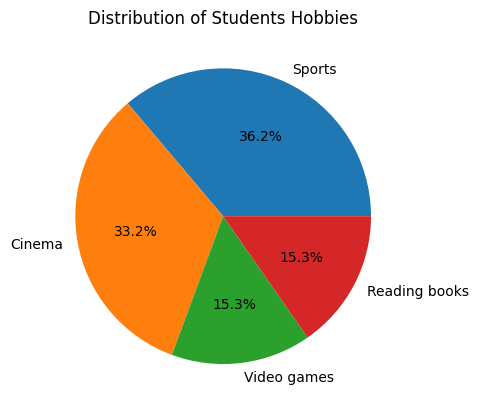

In [31]:
# Create a color palette
colors = plt.cm.get_cmap("viridis", len(df["hobbies"].unique()))#inferno/plasma/viridis colors

# Plot the value counts of certification courses with different colors
df["hobbies"].value_counts().plot(kind="bar", color=colors(range(len(df["hobbies"].unique()))))

# Add labels and title
plt.xlabel("Students Hobbies ")
plt.ylabel("Number of Students")
plt.title("Distribution of Students Hobbies")
plt.xticks(rotation=45)
plt.show()
df["hobbies"].value_counts().plot(kind="pie", autopct='%1.1f%%',title="Distribution of Students Hobbies",ylabel="")
plt.show()

<ipython-input-32-85bc413e01fb>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(df["stresslevel"].unique()))#inferno/plasma/viridis colors


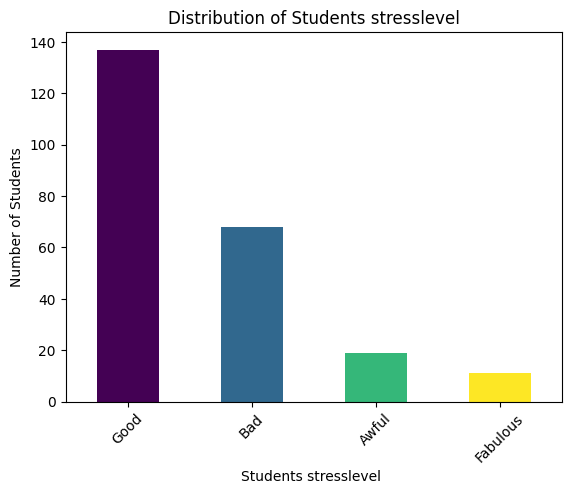

In [32]:
# Create a color palette
colors = plt.cm.get_cmap("viridis", len(df["stresslevel"].unique()))#inferno/plasma/viridis colors

# Plot the value counts of certification courses with different colors
df["stresslevel"].value_counts().plot(kind="bar", color=colors(range(len(df["stresslevel"].unique()))))

# Add labels and title
plt.xlabel("Students stresslevel ")
plt.ylabel("Number of Students")
plt.title("Distribution of Students stresslevel")
plt.xticks(rotation=45)
plt.show()

<ipython-input-33-752b26386469>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(df["prefertimetostudy"].unique()))#inferno/plasma/viridis colors


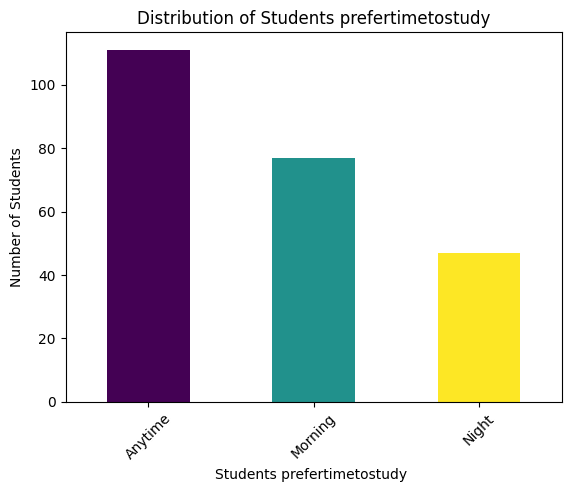

In [33]:
# Create a color palette
colors = plt.cm.get_cmap("viridis", len(df["prefertimetostudy"].unique()))#inferno/plasma/viridis colors

# Plot the value counts of certification courses with different colors
df["prefertimetostudy"].value_counts().plot(kind="bar", color=colors(range(len(df["prefertimetostudy"].unique()))))

# Add labels and title
plt.xlabel("Students prefertimetostudy ")
plt.ylabel("Number of Students")
plt.title("Distribution of Students prefertimetostudy")
plt.xticks(rotation=45)
plt.show()

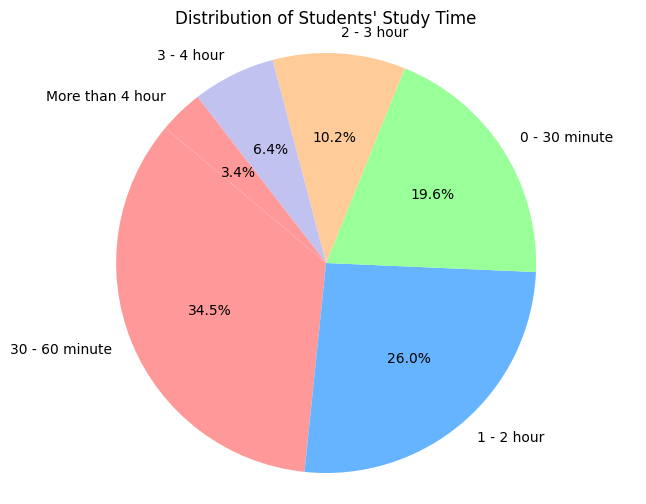

In [34]:
# Calculate the value counts for the studytime column
studytime_counts = df["studytime"].value_counts()

# Define a custom color palette
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']  # You can add more colors as needed

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(studytime_counts, labels=studytime_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Add title
plt.title("Distribution of Students' Study Time")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


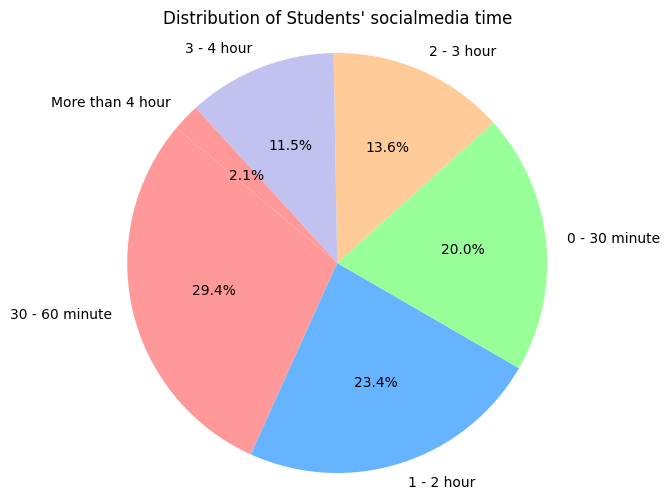

In [35]:
# Calculate the value counts for the studytime column
socialmed_tim_counts = df["socialmed_time"].value_counts()

# Define a custom color palette
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']  # You can add more colors as needed

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(socialmed_tim_counts, labels=studytime_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Add title
plt.title("Distribution of Students' socialmedia time")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

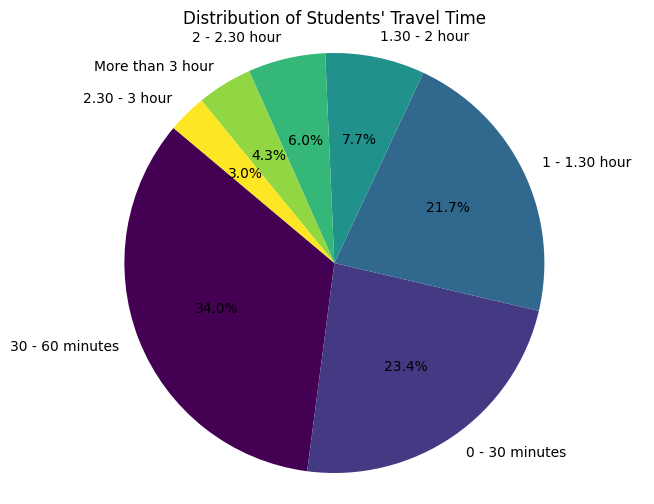

In [36]:
# Calculate the value counts for the travelTime column
travelTime_counts = df["travelTime"].value_counts()

# Define a colormap
cmap = plt.get_cmap("viridis", len(travelTime_counts))  # Specify the number of colors

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(travelTime_counts,
        labels=travelTime_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=[cmap(i) for i in range(len(travelTime_counts))])  # Use distinct colors

# Add title
plt.title("Distribution of Students' Travel Time")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

<ipython-input-37-91b7d58f31b7>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


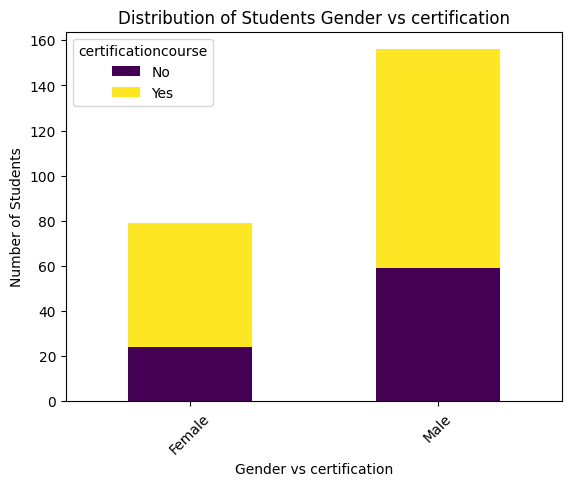

In [37]:
# Gender vs certification
# Group by gender and certification course, then count occurrences
grouped_data = df.groupby("gender")["certificationcourse"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="bar", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.xlabel("Gender vs certification")
plt.ylabel("Number of Students")
plt.title("Distribution of Students Gender vs certification")
plt.xticks(rotation=45)
plt.show()

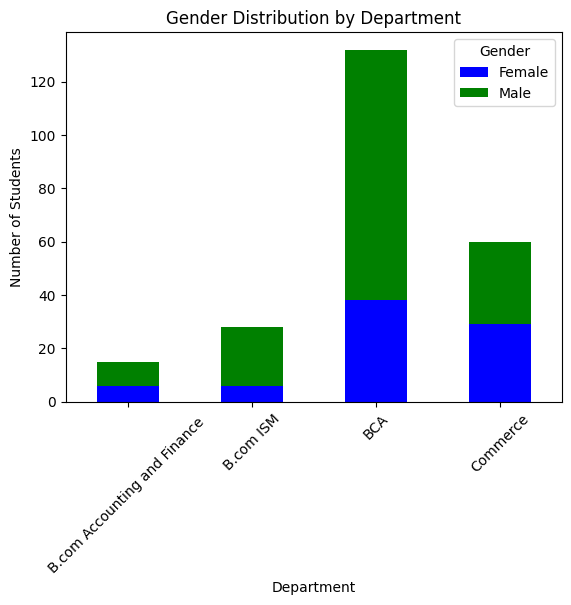

In [38]:

# Create a DataFrame with counts of genders in each department
gender_distribution = df.groupby('Department')['gender'].value_counts().unstack()

# Plot the stacked bar chart
gender_distribution.plot(kind='bar', stacked=True, color=['blue', 'green'])

# Add labels and title
plt.xlabel("Department")
plt.ylabel("Number of Students")
plt.title("Gender Distribution by Department")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Gender")
plt.show()

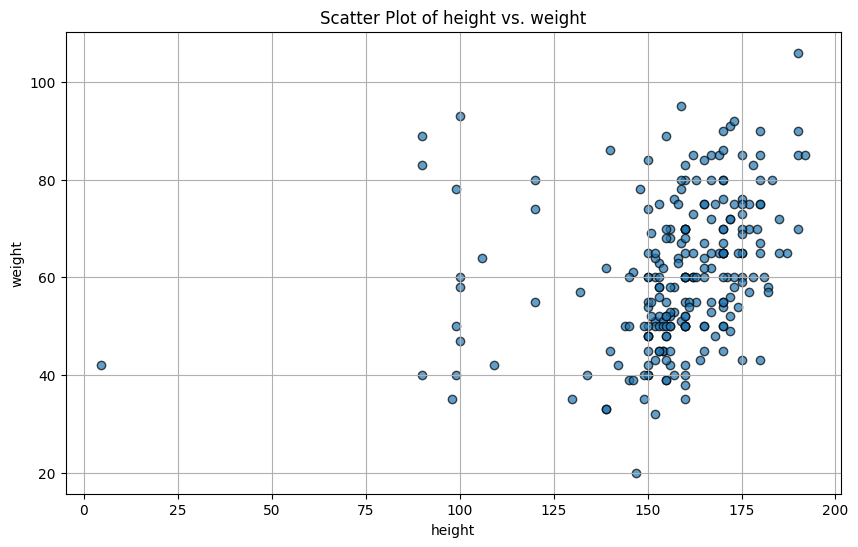

In [39]:
#Select relevant columns and handle NaN values
data = df[['height', 'weight']].dropna()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['height'], data['weight'], alpha=0.7, edgecolors='k')

# Add labels and title
plt.title('Scatter Plot of height vs. weight')
plt.xlabel('height')
plt.ylabel('weight')
plt.grid(True)

# Show the plot
plt.show()


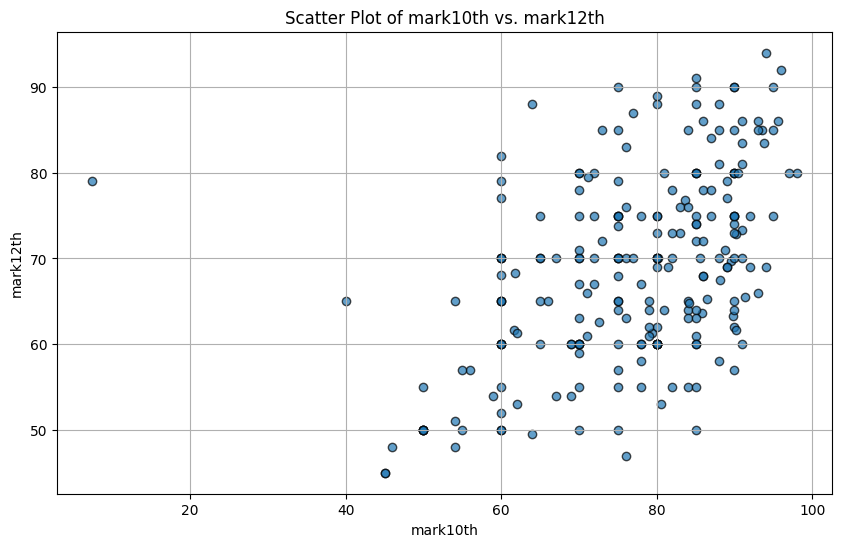

In [40]:
#Select relevant columns and handle NaN values
data = df[['mark10th', 'mark12th']].dropna()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['mark10th'], data['mark12th'], alpha=0.7, edgecolors='k')

# Add labels and title
plt.title('Scatter Plot of mark10th vs. mark12th')
plt.xlabel('mark10th')
plt.ylabel('mark12th')
plt.grid(True)

# Show the plot
plt.show()


## Relationship bitween stress level and other variables

<ipython-input-41-85e1f7cc4a55>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


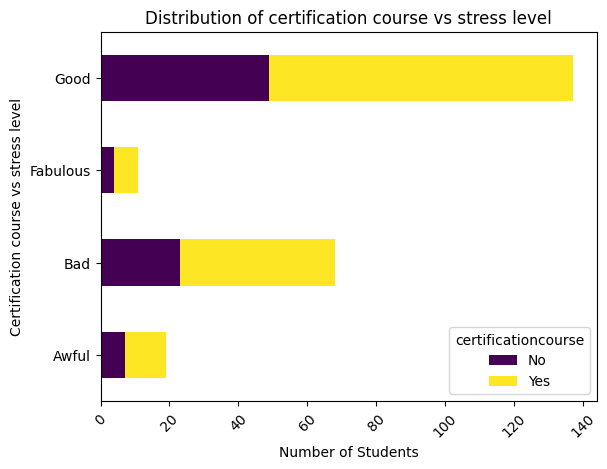

In [41]:
# stresslevel vs certification
grouped_data = df.groupby("stresslevel")["certificationcourse"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Certification course vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of certification course vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-42-9aac793120a4>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


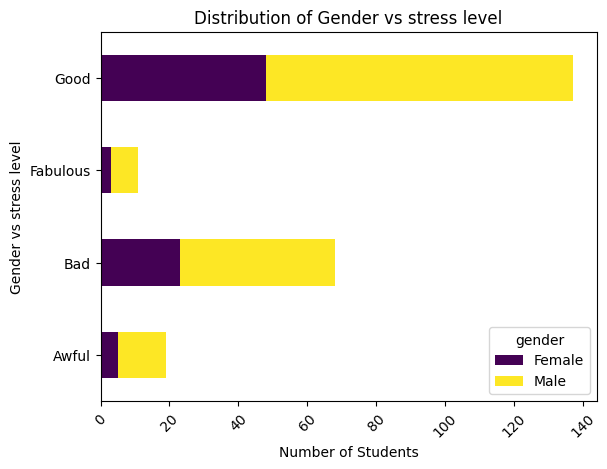

In [42]:
# Gender vs certification
grouped_data = df.groupby("stresslevel")["gender"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Gender vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of Gender vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-43-17bcfe5c3a51>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


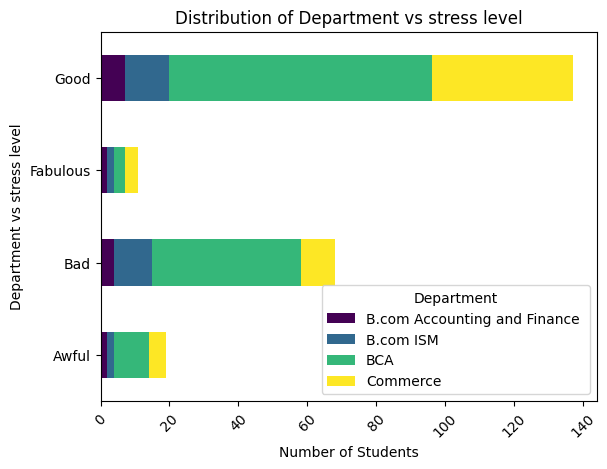

In [43]:
# Department vs certification
grouped_data = df.groupby("stresslevel")["Department"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Department vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of Department vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-44-be378f120042>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


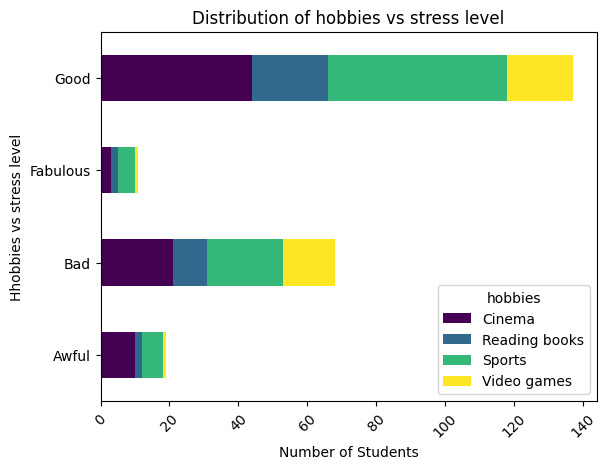

In [44]:
# hobbies vs certification
grouped_data = df.groupby("stresslevel")["hobbies"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Hhobbies vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of hobbies vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-45-06b35edf2b91>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


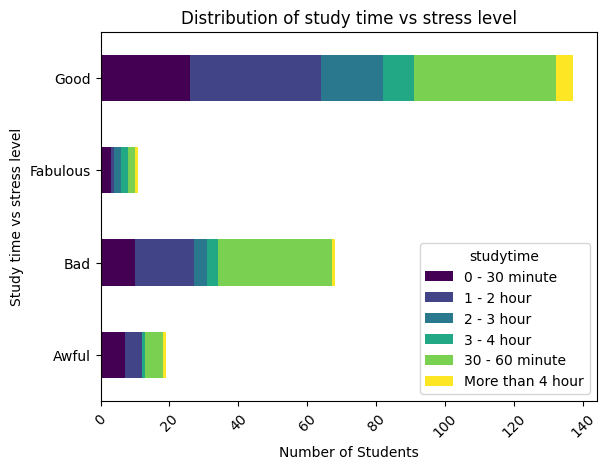

In [45]:
# studytime vs certification
grouped_data = df.groupby("stresslevel")["studytime"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Study time vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of study time vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-46-6f3b7003f071>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


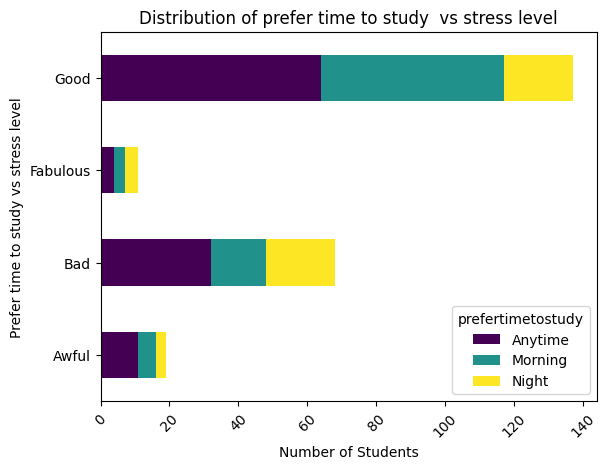

In [46]:
# prefertimetostudy vs certification
grouped_data = df.groupby("stresslevel")["prefertimetostudy"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Prefer time to study vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of prefer time to study  vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-47-b02cce7ef9c8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


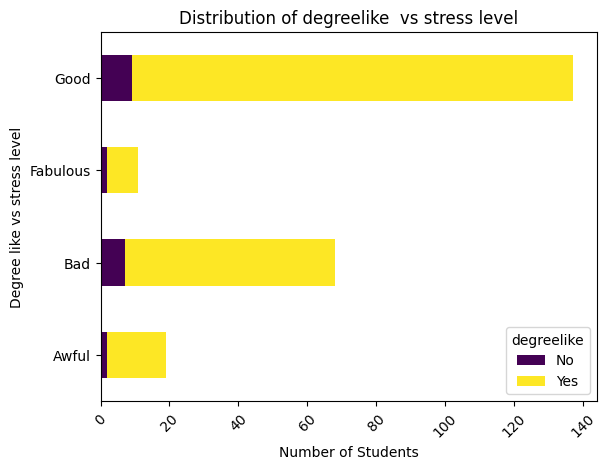

In [47]:
# degreelike vs certification
grouped_data = df.groupby("stresslevel")["degreelike"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Degree like vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of degreelike  vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-48-03b9b04face7>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


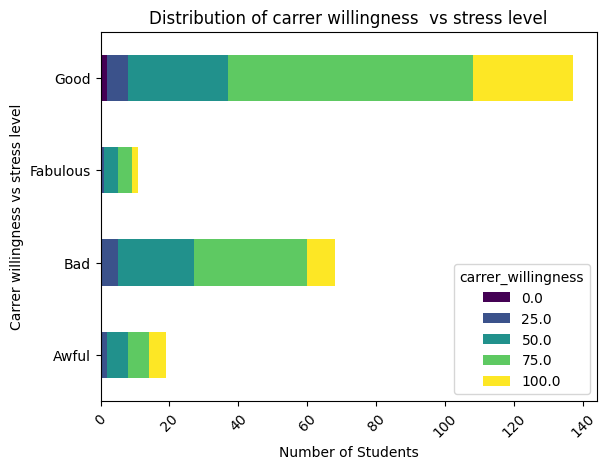

In [48]:
# carrer_willingness vs certification
grouped_data = df.groupby("stresslevel")["carrer_willingness"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Carrer willingness vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of carrer willingness  vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-49-23602e9ae4fd>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


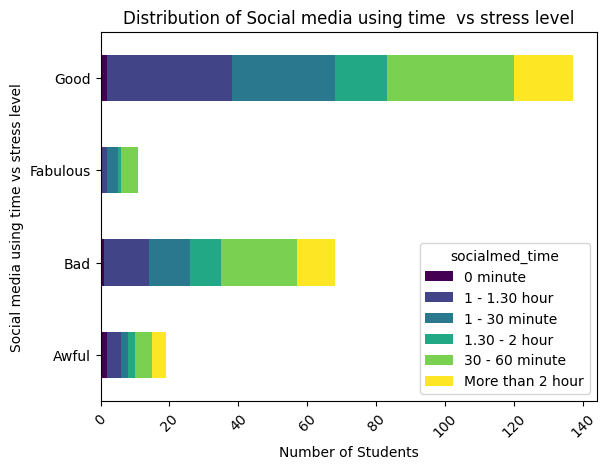

In [49]:
# socialmed_time vs certification
grouped_data = df.groupby("stresslevel")["socialmed_time"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Social media using time vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of Social media using time  vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-50-93f319192aa8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


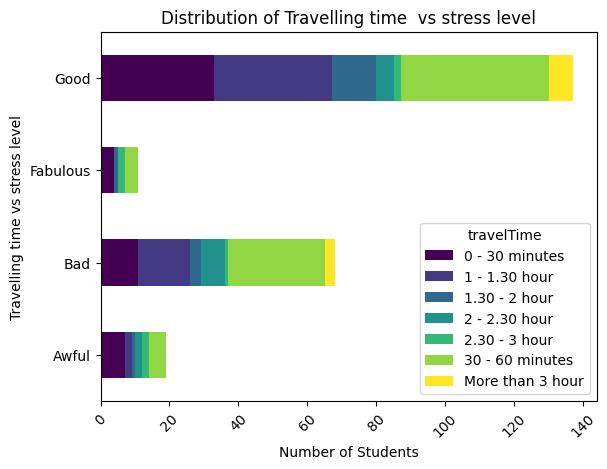

In [50]:
# Travelling time vs certification
grouped_data = df.groupby("stresslevel")["travelTime"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Travelling time vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of Travelling time  vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-51-0ede8d7dd02f>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


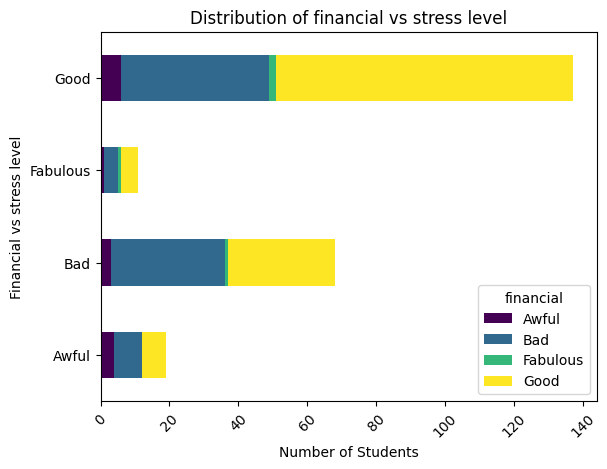

In [51]:
# financial  vs certification
grouped_data = df.groupby("stresslevel")["financial"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Financial vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of financial vs stress level")
plt.xticks(rotation=45)
plt.show()

<ipython-input-52-48b00067ce91>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))


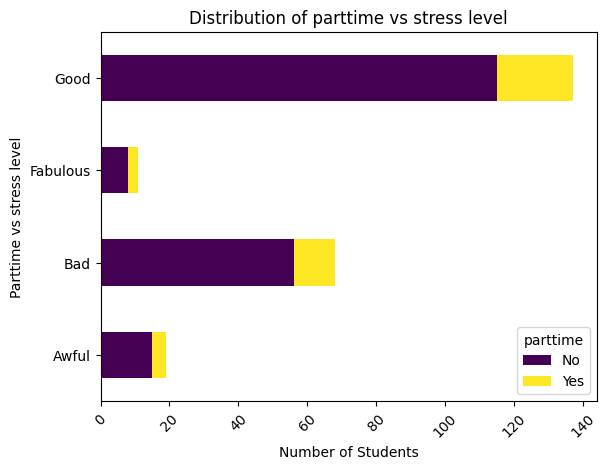

In [52]:
# parttime  vs certification
grouped_data = df.groupby("stresslevel")["parttime"].value_counts().unstack()

# Create a color palette
colors = plt.cm.get_cmap("viridis", len(grouped_data.columns))

# Plot the data as a bar plot with different colors
grouped_data.plot(kind="barh", stacked=True, color=colors(range(len(grouped_data.columns))))

# Add labels and title
plt.ylabel("Parttime vs stress level")
plt.xlabel("Number of Students")
plt.title("Distribution of parttime vs stress level")
plt.xticks(rotation=45)
plt.show()

Height Range:  4.5 to 192.0
   height       height_bin
0   100.0    4.50 - 150.00
1    90.0    4.50 - 150.00
2   159.0  156.00 - 163.00
3   147.0    4.50 - 150.00
4   170.0  163.00 - 172.00


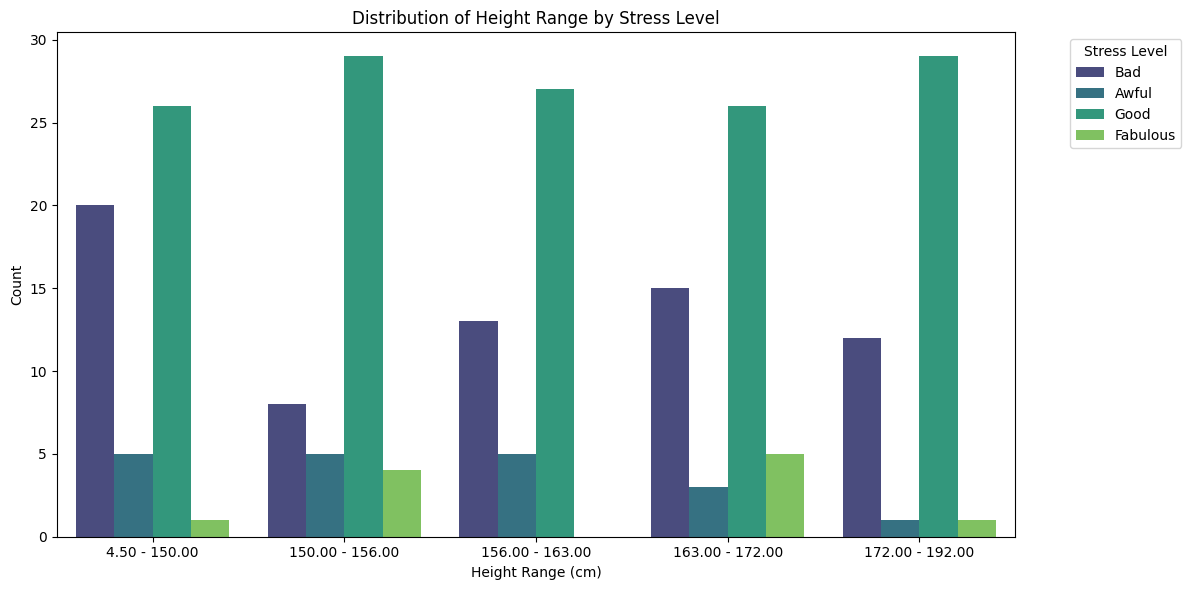

In [53]:
# Display the range of height data for reference
print("Height Range: ", df['height'].min(), "to", df['height'].max())

# Automatically create 5 quantile-based bins for height and get bin edges
df['height_bin'], bin_edges = pd.qcut(df['height'], q=5, retbins=True)

# Update the height_bin column with labels based on bin_edges
bin_labels = [f'{bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}' for i in range(len(bin_edges)-1)]
df['height_bin'] = pd.qcut(df['height'], q=5, labels=bin_labels)

# Display the first few rows to see the new column
print(df[['height', 'height_bin']].head())

# Plotting the distribution of height bins by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='height_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('Height Range (cm)')
plt.ylabel('Count')
plt.title('Distribution of Height Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


Weight Range:  20.0 to 106.0
   weight      weight_bin
0    58.0   55.00 - 65.00
1    40.0   20.00 - 48.00
2    78.0  75.00 - 106.00
3    20.0   20.00 - 48.00
4    54.0   48.00 - 55.00


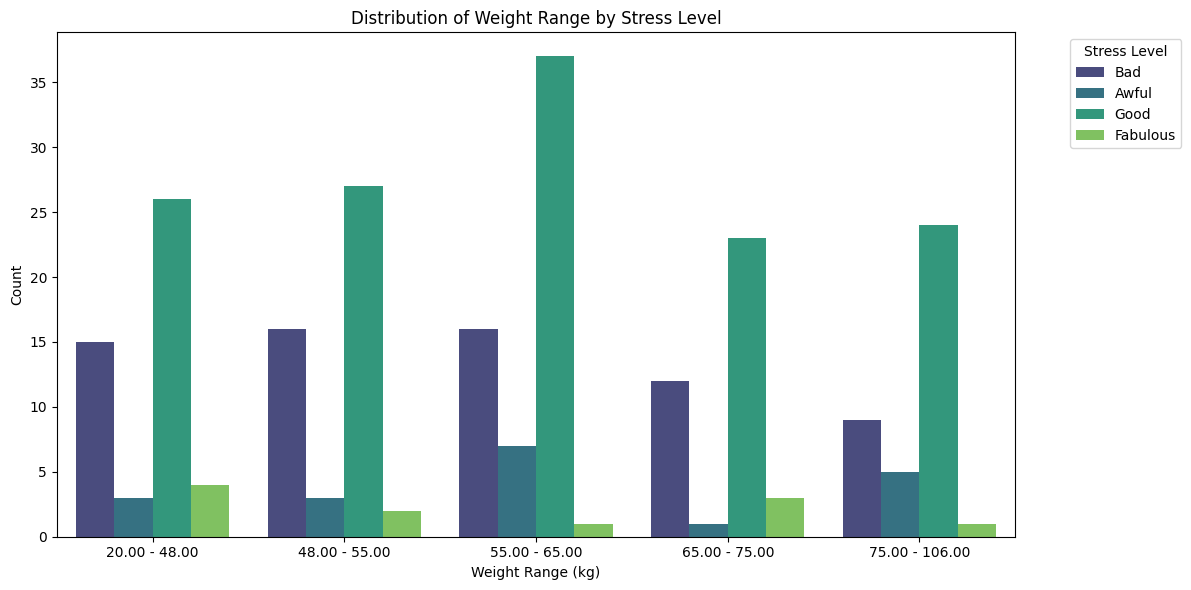

In [54]:
# Display the range of weight data for reference
print("Weight Range: ", df['weight'].min(), "to", df['weight'].max())

# Automatically create 5 quantile-based bins for weight and get bin edges
df['weight_bin'], bin_edges = pd.qcut(df['weight'], q=5, retbins=True)

# Update the weight_bin column with labels based on bin_edges
bin_labels = [f'{bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}' for i in range(len(bin_edges) - 1)]
df['weight_bin'] = pd.qcut(df['weight'], q=5, labels=bin_labels)

# Display the first few rows to see the new column
print(df[['weight', 'weight_bin']].head())

# Plotting the distribution of weight bins by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='weight_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('Weight Range (kg)')
plt.ylabel('Count')
plt.title('Distribution of Weight Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


salexpect Range:  0 to 1500000
   salexpect          salexpect_bin
0      40000  25000.00 - 1500000.00
1      15000        0.00 - 15000.00
2      13000        0.00 - 15000.00
3    1500000  25000.00 - 1500000.00
4      50000  25000.00 - 1500000.00


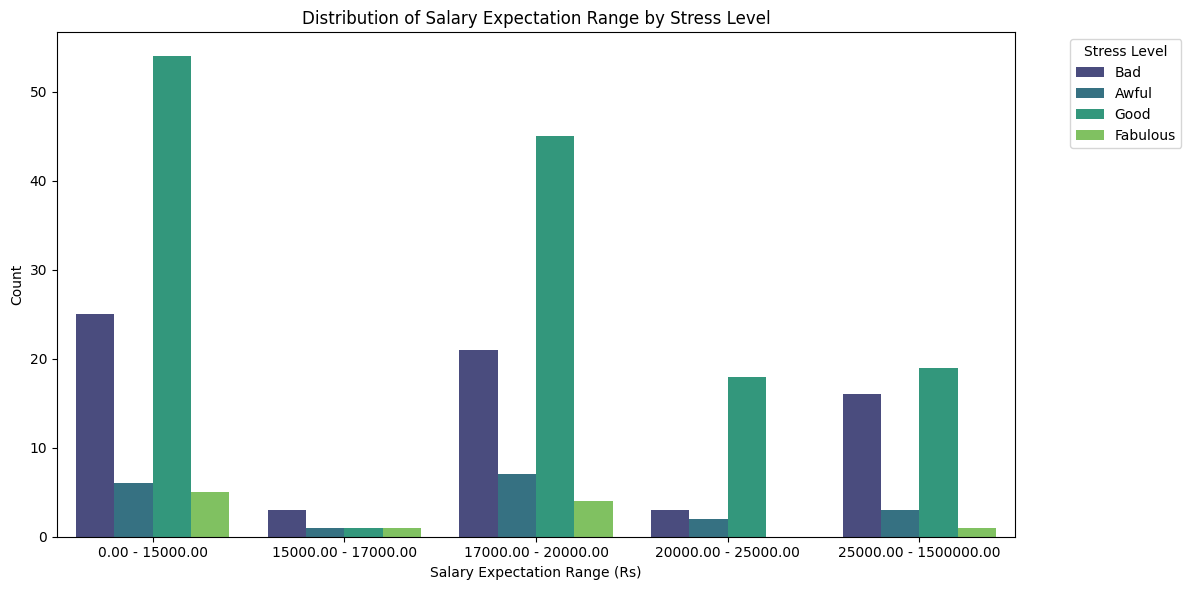

In [55]:
# Display the range of salexpect data for reference
print("salexpect Range: ", df['salexpect'].min(), "to", df['salexpect'].max())

# Automatically create 5 quantile-based bins for salexpect and get bin edges
df['salexpect_bin'], bin_edges = pd.qcut(df['salexpect'], q=5, retbins=True)

# Define labels using the bin edges after they've been created
bin_labels = [f'{bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}' for i in range(len(bin_edges) - 1)]
df['salexpect_bin'] = pd.qcut(df['salexpect'], q=5, labels=bin_labels)

# Display the first few rows to see the new column
print(df[['salexpect', 'salexpect_bin']].head())

# Plotting the distribution of salexpect bins by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='salexpect_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('Salary Expectation Range (Rs)')
plt.ylabel('Count')
plt.title('Distribution of Salary Expectation Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


   mark10th mark10th_bin
0      79.0      60 - 80
1      70.0      60 - 80
2      71.0      60 - 80
3      70.0      60 - 80
4      40.0       0 - 40


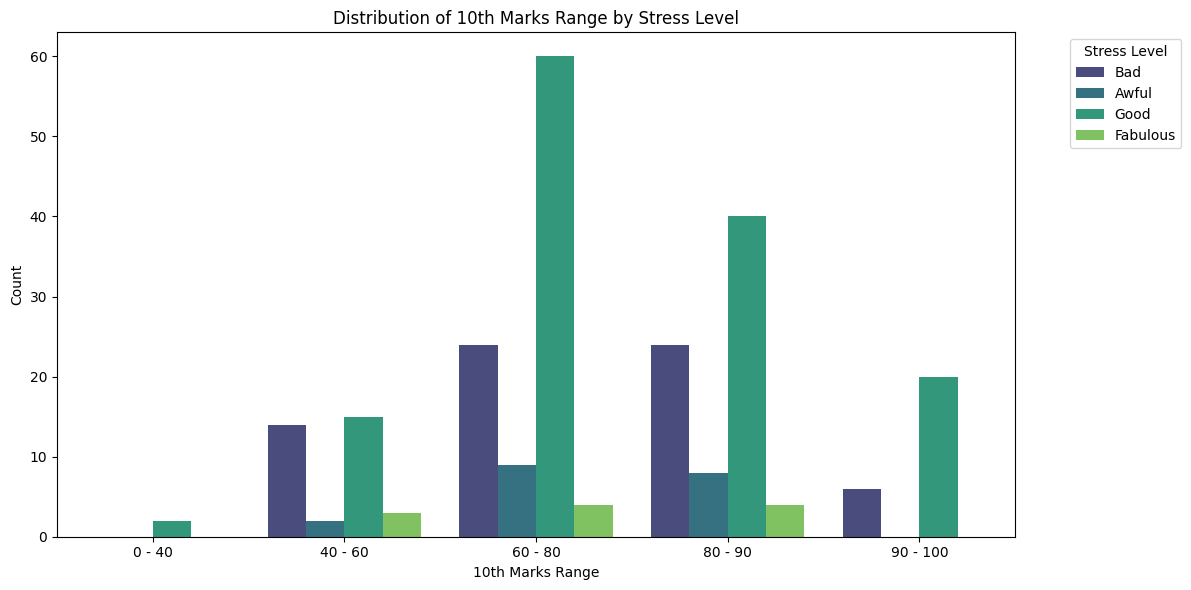

In [56]:
# Convert mark10th to numeric, in case it has been read as an object
df['mark10th'] = pd.to_numeric(df['mark10th'], errors='coerce')

# Define custom bin edges based on typical ranges for marks
bin_edges = [0, 40, 60, 80, 90, 100]

# Automatically create bins using the defined edges
df['mark10th_bin'] = pd.cut(
    df['mark10th'],
    bins=bin_edges,
    labels=[f'{bin_edges[i]} - {bin_edges[i + 1]}' for i in range(len(bin_edges) - 1)],
    include_lowest=True
)

# Display the first few rows to see the new column
print(df[['mark10th', 'mark10th_bin']].head())

# Plotting the distribution of 10th marks range by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='mark10th_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('10th Marks Range')
plt.ylabel('Count')
plt.title('Distribution of 10th Marks Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


   mark12th mark12th_bin
0      64.0      60 - 80
1      80.0      60 - 80
2      61.0      60 - 80
3      59.0      40 - 60
4      65.0      60 - 80


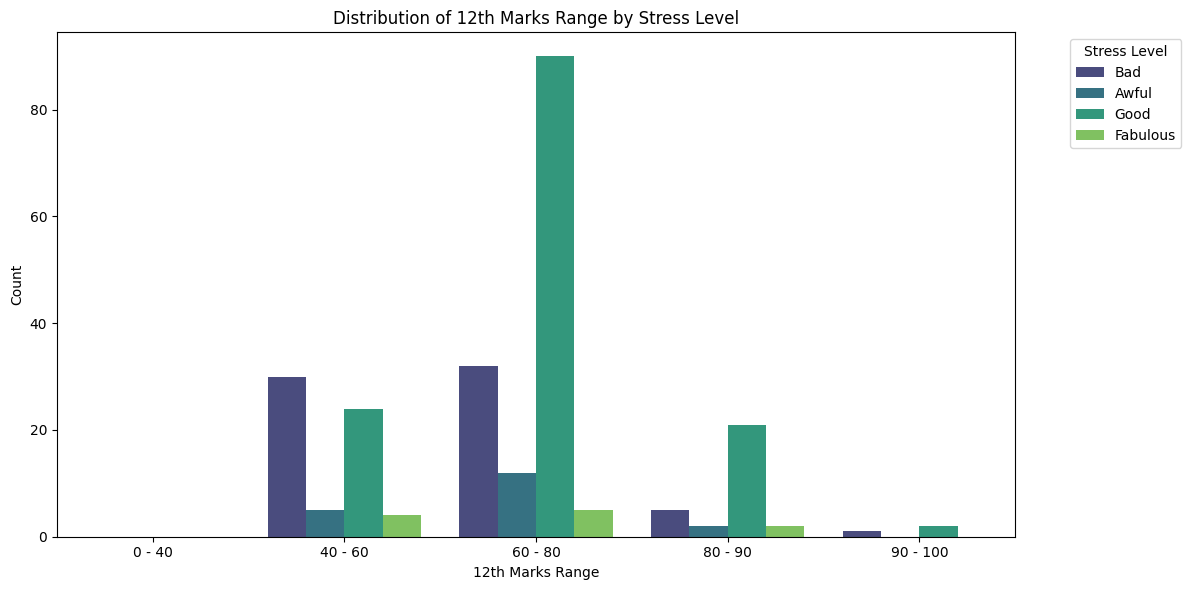

In [57]:
# Convert mark12th to numeric, in case it has been read as an object
df['mark12th'] = pd.to_numeric(df['mark12th'], errors='coerce')

# Define custom bin edges based on typical ranges for marks
bin_edges = [0, 40, 60, 80, 90, 100]

# Automatically create bins using the defined edges
df['mark12th_bin'] = pd.cut(
    df['mark12th'],
    bins=bin_edges,
    labels=[f'{bin_edges[i]} - {bin_edges[i + 1]}' for i in range(len(bin_edges) - 1)],
    include_lowest=True
)

# Display the first few rows to see the new column
print(df[['mark12th', 'mark12th_bin']].head())

# Plotting the distribution of 12th marks range by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='mark12th_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('12th Marks Range')
plt.ylabel('Count')
plt.title('Distribution of 12th Marks Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


   collegemark collegemark_bin
0         80.0         60 - 80
1         70.0         60 - 80
2         55.0         40 - 60
3         58.0         40 - 60
4         30.0          0 - 40


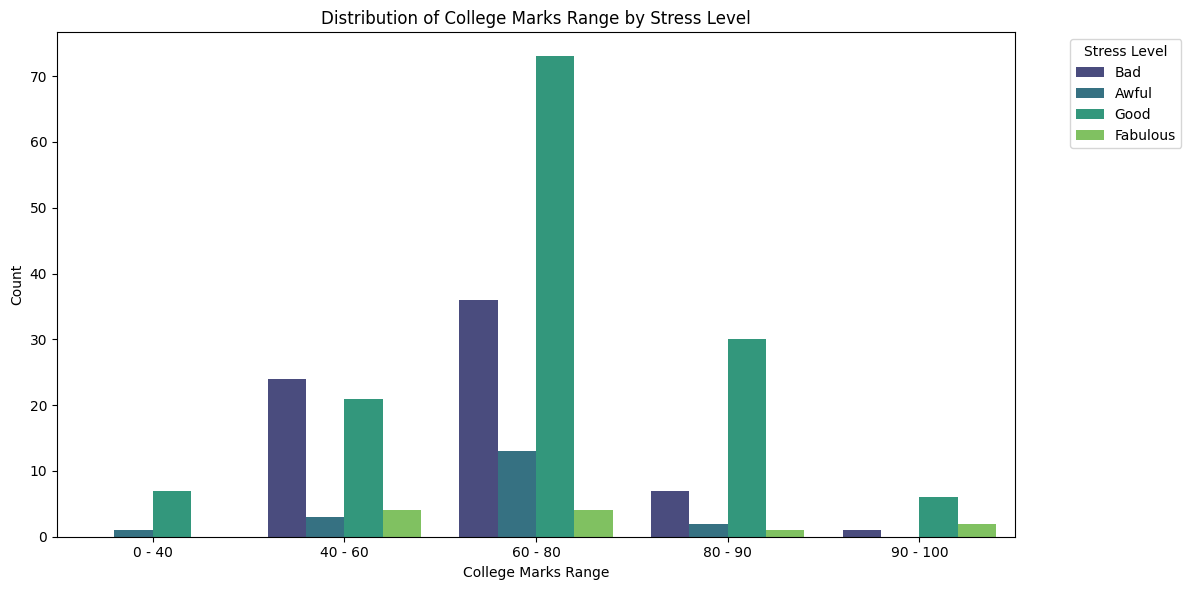

In [58]:
# Convert collegemark to numeric, in case it has been read as an object
df['collegemark'] = pd.to_numeric(df['collegemark'], errors='coerce')

# Define custom bin edges based on typical ranges for college marks
bin_edges = [0, 40, 60, 80, 90, 100]  # Adjust these ranges as needed

# Automatically create bins using the defined edges
df['collegemark_bin'] = pd.cut(
    df['collegemark'],
    bins=bin_edges,
    labels=[f'{bin_edges[i]} - {bin_edges[i + 1]}' for i in range(len(bin_edges) - 1)],
    include_lowest=True
)

# Display the first few rows to see the new column
print(df[['collegemark', 'collegemark_bin']].head())

# Plotting the distribution of college marks range by stress level
plt.figure(figsize=(12, 6))
sns.countplot(x='collegemark_bin', hue='stresslevel', data=df, palette='viridis')

# Set labels and title
plt.xlabel('College Marks Range')
plt.ylabel('Count')
plt.title('Distribution of College Marks Range by Stress Level')

# Add a legend for the stress levels
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


# Students Stress level Prediction


##Using Random forest

[I 2024-11-01 07:09:55,076] A new study created in memory with name: no-name-f1405077-d69e-4507-a01e-3fbb74bf55c5
[I 2024-11-01 07:10:02,159] Trial 0 finished with value: 0.8090909090909091 and parameters: {'n_estimators': 236, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8090909090909091.
[I 2024-11-01 07:10:11,179] Trial 1 finished with value: 0.8090909090909091 and parameters: {'n_estimators': 385, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 0 with value: 0.8090909090909091.
[I 2024-11-01 07:10:23,943] Trial 2 finished with value: 0.7909090909090909 and parameters: {'n_estimators': 466, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8090909090909091.
[I 2024-11-01 07:10:34,014] Trial 3 finished with value: 0.7727272727272727 and parameters: {'n_estimators': 384, 'max_depth': 

Best Hyperparameters: {'n_estimators': 397, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'class_weight': None}
Model Accuracy: 0.8818181818181818
Classification Report:
               precision    recall  f1-score   support

       Awful       0.96      0.96      0.96        24
         Bad       0.82      0.79      0.81        29
    Fabulous       1.00      0.96      0.98        28
        Good       0.77      0.83      0.80        29

    accuracy                           0.88       110
   macro avg       0.89      0.89      0.89       110
weighted avg       0.88      0.88      0.88       110



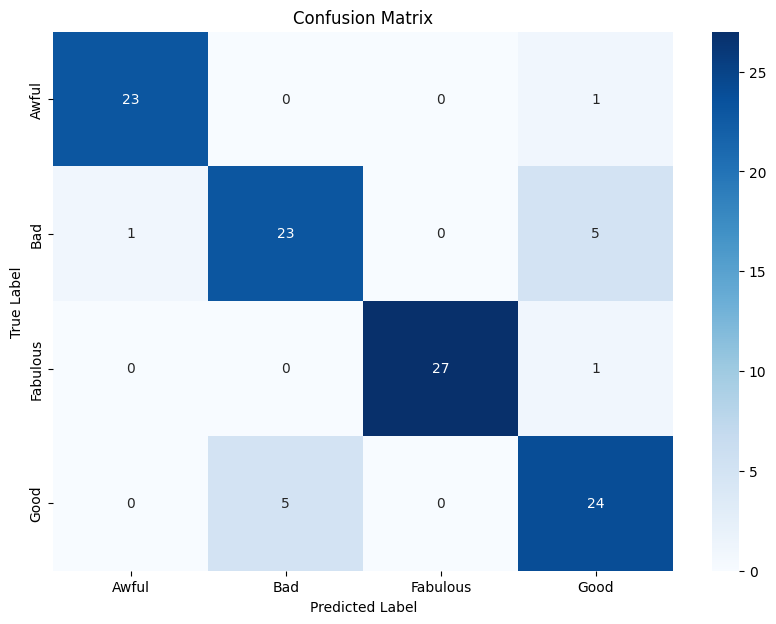

Random Forest Metrics:
Accuracy: 0.88
Recall: 0.88
F1-score: 0.88



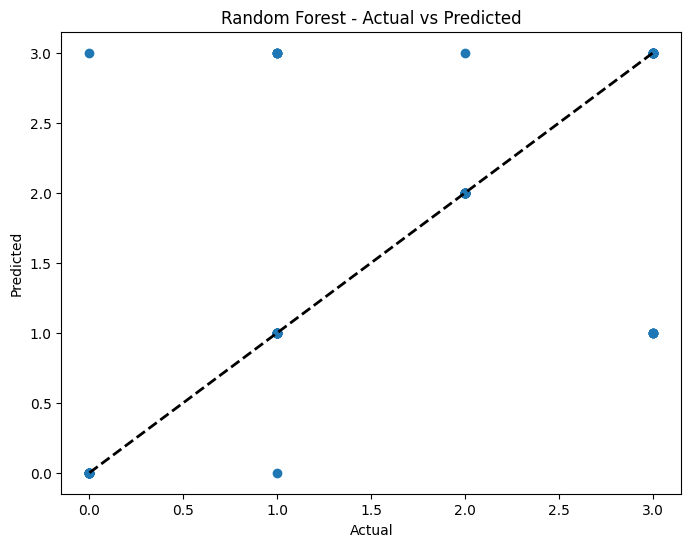

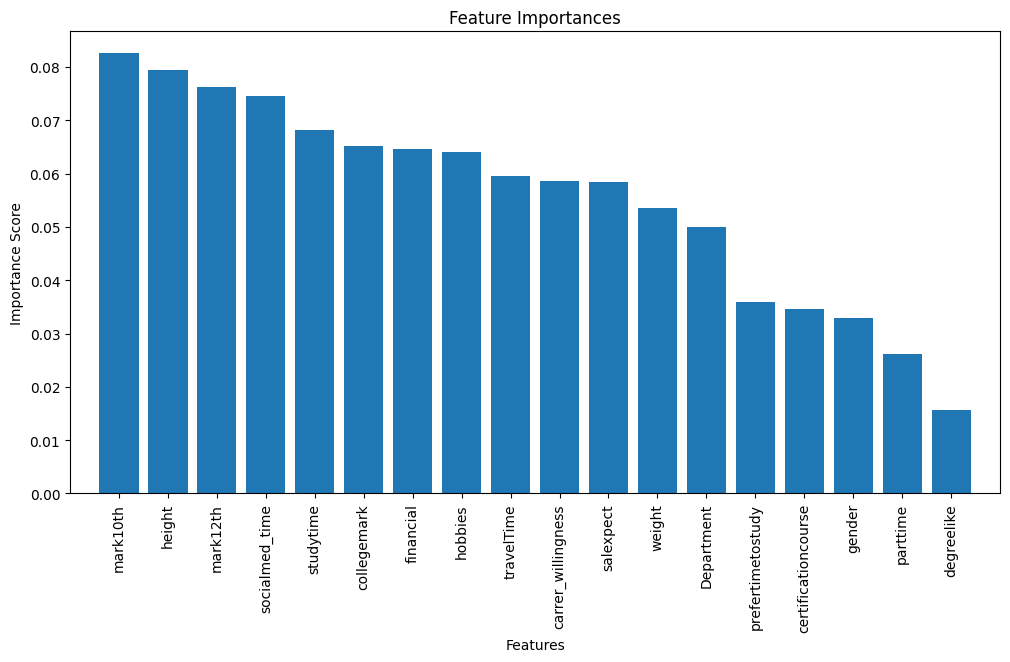

In [69]:

# Define target and features
target_column = 'stresslevel'
features = df.drop(columns=[target_column])
target = df[target_column]

# Define target and features, dropping unneeded columns
exclude_columns = ['stresslevel_numeric','mark10th_bin', 'height_bin', 'weight_bin', 'salexpect_bin', 'mark12th_bin', 'collegemark_bin']

features = df.drop(columns=[target_column] + exclude_columns)
target = df[target_column]

# Encode categorical variables
label_encoders = {}
for column in features.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column].astype(str))
    label_encoders[column] = le

# Standardize numerical features
scaler = StandardScaler()
features[features.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(features.select_dtypes(include=['float64', 'int64']))

# Encode the target variable
target_encoder = LabelEncoder()
target = target_encoder.fit_transform(target.astype(str))

# Resample data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define an objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    # Create a RandomForestClassifier with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42
    )

    # RFE for feature selection
    rfe = RFE(model, n_features_to_select=10)
    pipeline = Pipeline([('feature_selection', rfe), ('model', model)])
    pipeline.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = pipeline.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Bayesian optimization with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get the best parameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train and evaluate the model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#=======================
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
r2 = r2_score(y_test, y_pred)
print('Random Forest Metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print()
#=====================

# Plotting actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest - Actual vs Predicted')
plt.show()

#=========
# Get feature importances
importances = best_rf_model.feature_importances_

# Get the feature names that are not excluded
features_to_plot = [feature for feature in features.columns if feature not in exclude_columns]

# Create an array of importances for the features to plot
importances_to_plot = [importances[i] for i, feature in enumerate(features.columns) if feature in features_to_plot]

# Get the sorted indices for plotting
indices = np.argsort(importances_to_plot)[::-1]

# Sort features and importances according to the indices
sorted_features = [features_to_plot[i] for i in indices]
sorted_importances = [importances_to_plot[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlim([-1, len(sorted_importances)])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


# Using Decision Tree

[I 2024-11-01 06:57:47,529] A new study created in memory with name: no-name-2ea838bf-19a1-4a15-bdda-08add8ba9e13
[I 2024-11-01 06:57:47,929] Trial 0 finished with value: 0.8454545454545455 and parameters: {'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 1, 'class_weight': None}. Best is trial 0 with value: 0.8454545454545455.
[I 2024-11-01 06:57:48,316] Trial 1 finished with value: 0.8636363636363636 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': None}. Best is trial 1 with value: 0.8636363636363636.
[I 2024-11-01 06:57:48,761] Trial 2 finished with value: 0.8272727272727273 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8636363636363636.
[I 2024-11-01 06:57:49,130] Trial 3 finished with value: 0.8181818181818182 and parameters: {'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 1 

Best Hyperparameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None}
Model Accuracy: 0.8818181818181818
Classification Report:
               precision    recall  f1-score   support

       Awful       0.88      0.92      0.90        24
         Bad       0.86      0.83      0.84        29
    Fabulous       1.00      1.00      1.00        28
        Good       0.79      0.79      0.79        29

    accuracy                           0.88       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110

Decision Tree Metrics:
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1-score: 0.88


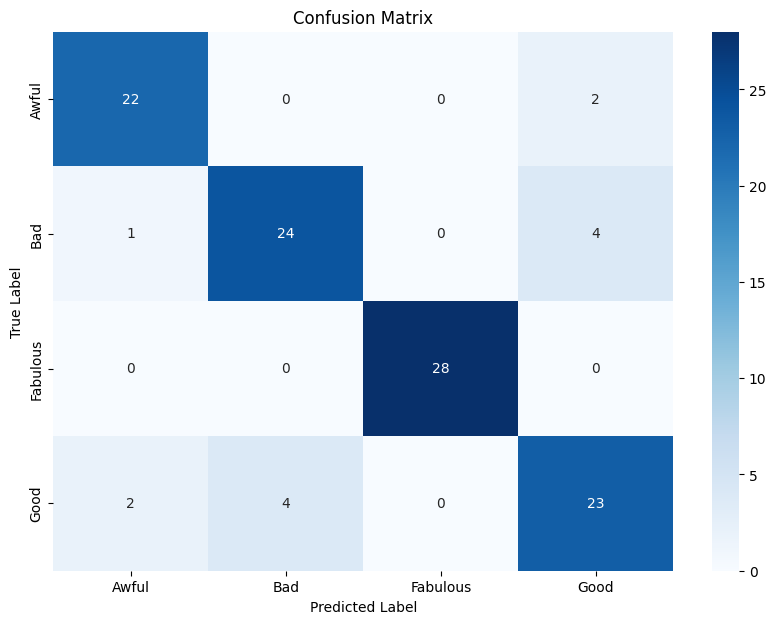

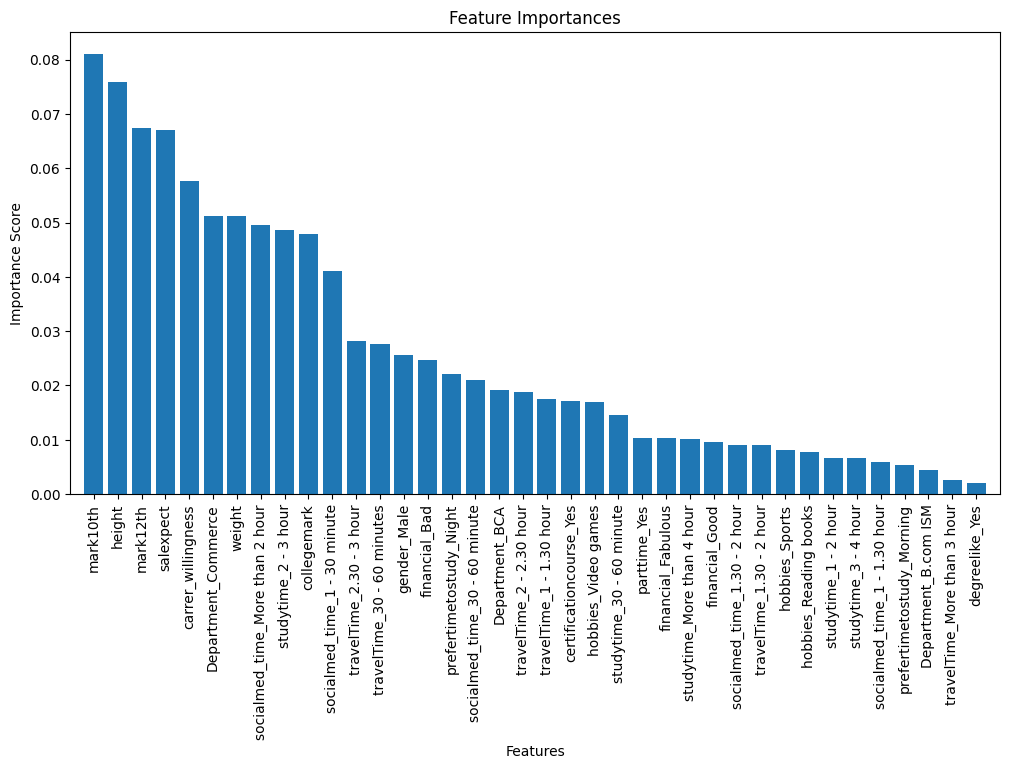

In [61]:
# Define feature engineering and exclude specified columns
exclude_columns = ['mark10th_bin', 'height_bin', 'weight_bin', 'salexpect_bin', 'mark12th_bin', 'collegemark_bin']
X = df.drop(columns=['stresslevel', 'stresslevel_numeric'] + exclude_columns)
y = df["stresslevel"]

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Apply SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using Optuna for Decision Tree model
def objective(trial):
    # Define the hyperparameters to tune
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    # Decision Tree within Bagging Classifier for stability
    model = BaggingClassifier(
        DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42,
        ),
        n_estimators=50,  # Using 50 trees in the Bagging ensemble
        random_state=42,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Running Optuna to find best parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train final model with best hyperparameters
final_model = BaggingClassifier(
    DecisionTreeClassifier(
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        class_weight=best_params["class_weight"],
        random_state=42,
    ),
    n_estimators=50,
    random_state=42,
)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_final)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_final))

# Additional Metrics
precision = precision_score(y_test, y_pred_final, average='weighted')
recall = recall_score(y_test, y_pred_final, average='weighted')
f1 = f1_score(y_test, y_pred_final, average='weighted')
print('Decision Tree Metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate average feature importances across all estimators in the Bagging ensemble
importances = np.mean([
    tree.feature_importances_ for tree in final_model.estimators_
], axis=0)

# Ensure the feature names match
features = X.columns

# Sort and plot feature importances
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlim([-1, len(sorted_importances)])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

